In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pywt
from tsfresh.feature_extraction import feature_calculators
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
cgm = pd.read_csv('CSE572/mealData1.csv', usecols=list(range(30)) , names=list(range(30)) )
labels = []
for i in range(2,6):
    tmp = pd.read_csv('CSE572/mealData'+str(i)+'.csv', usecols=list(range(30)) , names=list(range(30)))
    cgm = cgm.append(tmp)

labels.extend([1]*cgm.shape[0])

for i in range(1,6):
    tmp = pd.read_csv('CSE572/Nomeal'+str(i)+'.csv', usecols=list(range(30)) , names=list(range(30)))
    cgm = cgm.append(tmp)
    labels.extend([0]*tmp.shape[0])

print(cgm.head())
print(cgm.shape)
cgm = cgm.astype('float')#.values
nrows = cgm.shape[0]
ncolumns = cgm.shape[1]

    0    1    2    3    4    5   ...     24     25     26     27     28     29
0  221  232  240  244  245  246  ...  245.0  242.0  239.0  235.0  231.0  226.0
1   55   62   70   79   89  100  ...  144.0  139.0  138.0  138.0  139.0  139.0
2  214  213  211  210  205  200  ...   79.0   79.0   81.0   82.0   84.0   86.0
3  226  224  228  222  214  206  ...  143.0  148.0  149.0  148.0  153.0  155.0
4  188  181  176  174  172  170  ...  100.0   99.0  100.0  101.0  100.0   95.0

[5 rows x 30 columns]
(463, 30)


In [0]:
degree = 7
polyCoeff = np.zeros((nrows,degree+1))
for i in range(nrows): polyCoeff[i,:] = np.polyfit(range(0,150,5),cgm.iloc[i,:], deg=degree)
#print(polyCoeff)

fft = np.zeros((nrows,ncolumns))
for i in range(nrows):
    temp = np.fft.fft(cgm.iloc[i,:])
    fft[i,:] = np.absolute(temp)
#print(fft)

dwt_coeff = []
for i in range(nrows):

    (data, coeff_d) = pywt.dwt(cgm.iloc[i,:], 'db2')
    (data, coeff_d) = pywt.dwt(data, 'db2') # Apply 2 levels of approximation
    #print(len(coeff_d))
    dwt_coeff.append(coeff_d)

kurtosis = []
for i in range(nrows): kurtosis.append(feature_calculators.kurtosis(cgm.iloc[i,:]))
#print(kurtosis)

LAGE = np.zeros(nrows)
for i in range(nrows):
    LAGE[i] = np.max(cgm.iloc[i,:]) - np.min(cgm.iloc[i,:])
#print(lage)
"""
CGM_new = 1.509*(np.log(cgm)**1.084 - 5.381)
risk = 10*CGM_new**2

LBGI = np.zeros(nrows) ##Feature 2: Low Blood Glucose Index(LBGI)
HBGI = np.zeros(nrows) ##Feature 3: High Blood Glucose Index(HBGI)

for i in range(nrows):
    k=0
    for j in range(ncolumns):
        if CGM_new.iloc[i][j] < 0:
            LBGI[i] += risk.iloc[i][j]
            k+=1
        elif CGM_new.iloc[i][j] > 0:
            HBGI[i] += risk.iloc[i][j]
            k+=1
    if(k != 0):
        LBGI[i] = LBGI[i]/k
        HBGI[i] = HBGI[i]/k
"""
TIR = np.zeros(nrows)
for i in range(nrows):
    for j in range(1,ncolumns):
        if cgm.iloc[i][j] > 80.0 and cgm.iloc[i][j] < 180.0:
            TIR[i] += cgm.iloc[i][j] - cgm.iloc[i][j-1]
    TIR[i] = TIR[i]*-1

CONGA = np.zeros(nrows)
for i in range(nrows):
    temp = []
    for j in range(ncolumns-6):
        if  not pd.isnull(cgm.iloc[i][j+6]) and not pd.isnull(cgm.iloc[i][j]):
            temp.append(cgm.iloc[i][j+6] - cgm.iloc[i][j])
    if temp == []:
        CONGA[i] = 0
    else:
        CONGA[i] = np.std(temp)

fea_mat = ['']*nrows
for i in range(nrows):
    fea_mat[i] = np.concatenate((polyCoeff[i],fft[i,:8],dwt_coeff[i], np.asarray([kurtosis[i], LAGE[i], TIR[i], CONGA[i]])))

fea_mat = np.asarray(fea_mat)
nor_mat = preprocessing.normalize(fea_mat,axis=0, norm='max')

## Calculate the best number of components to be chosen for PCA

Text(0, 0.5, 'cumulative explained variance')

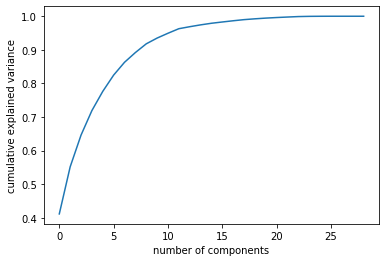

In [37]:
pca1 = PCA().fit(nor_mat.data)
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

##Apply PCA to dataset

In [38]:
pca = PCA(n_components=10)#Top 10 Features selected
dataset = pca.fit_transform(nor_mat)
#for i in range(len(dataset)):
#    print(dataset[i])
#print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.73941189 0.25179312 0.16986507 0.13129392 0.10278006 0.08704948
 0.06848665 0.05220742 0.0465812  0.03087683]
[0.41145107 0.1401121  0.09452264 0.07305945 0.0571927  0.04843931
 0.03810989 0.02905119 0.02592044 0.01718163]


## Train and Test Random Forest

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=250, random_state=0,)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[35 10]
 [16 32]]
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        45
           1       0.76      0.67      0.71        48

    accuracy                           0.72        93
   macro avg       0.72      0.72      0.72        93
weighted avg       0.73      0.72      0.72        93

0.7204301075268817
